In [16]:
%run metodos.ipynb # Importo metodos auxiliares
%mkdir -p outputs_medicion_error

In [17]:
import numpy as np
import subprocess
import numpy.linalg as linalg
import matplotlib.pyplot as plt

In [18]:
path_ejecutable = "./metodo_potencia"
path_instancias = "./outputs_medicion_error"
eps = 0.0000001

In [19]:
def correr_metodo_potencia(archivo, iteraciones, convergencia):
    process = subprocess.Popen(
        [path_ejecutable, archivo, str(iteraciones), str(convergencia)], 
        stderr=subprocess.PIPE, 
        stdout=subprocess.PIPE, 
        stdin=subprocess.PIPE, 
        universal_newlines = True)
    exit_code = process.wait()
    if exit_code != 0: 
        print(F"Hubo un error en la experimentacion con la instancia {archivo}")
        
    process.stdin.close();
    process.stdout.close();
    process.stderr.close();
    
def Autovalores(inputPath, niter, epsilon):
    correr_metodo_potencia(inputPath, niter, epsilon)
    eigenvalues = obtener_matriz(inputPath + "-autovalores.out", "f")
    eigenvectors = obtener_matriz(inputPath + "-autovectores.out", "f")
    
    return eigenvalues, eigenvectors

In [20]:
def ordernar(autoVals, autoVects):
    inds = autoVals.argsort()
    autoVals = autoVals[inds[::-1]]
    autoVects = autoVects.T
    autoVects = autoVects[inds[::-1]]
    autoVects = autoVects.T
    
    return autoVals, autoVects

def compararAutovalores(autoVals1, autoVals2):
    n = len(autoVals1)
    m = len(autoVals2)
    if n != m:
        return False
    sonIguales = True
    for i in range(n):
        sonIguales = sonIguales and abs(autoVals1[i] - autoVals2[i]) < eps
    return sonIguales

def compararAutovectores(one, two):
  abab = np.dot(one,two)*np.dot(one,two)
  aabb = np.dot(one,one)*np.dot(two,two)
  return abab > aabb*(1-eps)

def compararMatrizAutovectores(m1, m2):
    m1 = m1.T
    m2 = m2.T
    
    if len(m1) != len(m2):
        return False
    sonIguales = True
    for i in range(len(m1)):
        sonIguales = sonIguales and compararAutovectores(m1[i], m2[i])
    return sonIguales

def comparar(autoVals1, autoVects1, autoVals2, autoVects2):
    autoVals1, autoVects1 = ordernar(autoVals1, autoVects1)
    autoVals2, autoVects2 = ordernar(autoVals2, autoVects2)
    autovaloresIguales = compararAutovalores(autoVals1, autoVals2)
    autovectoresIguales = compararMatrizAutovectores(autoVects1, autoVects2)
    
    return autovectoresIguales and autovaloresIguales

def printToFile(M, path):
    
    f = open(path, "w")

    for row in M:
        for val in row:
            val = 0 if abs(val) < 1e-15 else val
            f.write(str(val) + " ")
        f.write("\n")

# Ejemplo

In [21]:
def ejemplo1():
    D = np.diag([5.0, 4.999, 4.998, 4.997, 4.996])

    v = np.ones((D.shape[0], 1))

    v = v / np.linalg.norm(v)

    # Matriz de Householder
    B = np.eye(D.shape[0]) - 2 * (v @ v.T)

    # Matriz a diagonalizar
    M = B.T @ D @ B
    return M
    
M = ejemplo1()
printToFile(M, F"{path_instancias}/autovectores_ejemplo.txt")

w, v = linalg.eig(M)
print("Output linalg.eig:")
print(w)
print(v)



a, b = Autovalores(F"{path_instancias}/autovectores_ejemplo.txt", 10000, eps)

print("Output implementación propia:")
print(a)
print(b)

print("Comparación: ¿Son equivalentes?")
print(comparar(w, v, a, b))

Output linalg.eig:
[4.996 5.    4.997 4.998 4.999]
[[ 0.4  0.6 -0.4  0.4  0.4]
 [ 0.4 -0.4 -0.4  0.4 -0.6]
 [ 0.4 -0.4 -0.4 -0.6  0.4]
 [ 0.4 -0.4  0.6  0.4  0.4]
 [-0.6 -0.4 -0.4  0.4  0.4]]
Output implementación propia:
[4.99991 4.99908 4.998   4.997   4.99601]
[[-0.439236  0.605288  0.395113  0.398751  0.354386]
 [ 0.211015 -0.645593  0.507168  0.395091  0.35409 ]
 [ 0.490319  0.200782 -0.587047  0.484161  0.374486]
 [ 0.509386  0.294886  0.317899 -0.596144  0.443974]
 [ 0.512501  0.299273  0.375475  0.308386 -0.641621]]
Comparación: ¿Son equivalentes?
False


# Experimentacion

In [59]:
def expIteraciones(max_iteraciones):
    res = []
    for i in range(max_iteraciones+1):
        if i < 1: continue
        D = np.diag([float(j) for j in range(10, 0 , -1)])

        v = np.ones((D.shape[0], 1))

        v = v / np.linalg.norm(v)

        # Matriz de Householder
        B = np.eye(D.shape[0]) - 2 * (v @ v.T)
    
        # Matriz a diagonalizar
        M = B.T @ D @ B

        printToFile(M, F"{path_instancias}/expIteraciones.txt")

        a, b = Autovalores(F"{path_instancias}/expIteraciones.txt", i, eps)
        errores = []
        for j in range(9, 0 , -1):
            Av = M @ b[:, j]
            ev = a[j] * b[:, j]

            errores.append(np.linalg.norm(Av - ev))
        print(str(i) + " " + str(np.mean(errores)))
        res.append(np.mean(errores))
    return res

def expMatricesCrecientes(max_tamanio_matrix):
    res = []
    for i in range(max_tamanio_matrix+1):
        if i < 2: continue
        D = np.diag([float(i) for i in range(i, 0 , -1)])

        v = np.ones((D.shape[0], 1))

        v = v / np.linalg.norm(v)

        # Matriz de Householder
        B = np.eye(D.shape[0]) - 2 * (v @ v.T)
    
        # Matriz a diagonalizar
        M = B.T @ D @ B

        printToFile(M, F"{path_instancias}/expMatricesCrecientes.txt")

        a, b = Autovalores(F"{path_instancias}/expMatricesCrecientes.txt", 100, eps)
        errores = []
        for j in range(i-1, 0 , -1):
            Av = M @ b[:, j]
            ev = a[j] * b[:, j]

            errores.append(np.linalg.norm(Av - ev))
        res.append(np.mean(errores))
        print(str(i) + " " + str(np.mean(errores)))
    return res

## Error segun cantidad de iteraciones

1 3.317180509951705
2 2.5147951094750374
3 1.6661704888839877
4 1.3025951661229587
5 0.9231963177407658
6 0.7178485610393578
7 0.5710251414134386
8 0.48892872991143643
9 0.3870621180944094
10 0.32089201469468437
11 0.2768804126264411
12 0.24784071386613857
13 0.23113292901951624
14 0.2279400194762044
15 0.24810702731191667
16 0.2912142955462338
17 0.2658567149064106
18 0.18891624237259766
19 0.15508664146436998
20 0.13505822237429083
21 0.11893913060622197
22 0.10261155698274373
23 0.08345337370472294
24 0.059501566247182246
25 0.030398527555269
26 0.027162202036899508
27 0.06024790661074072
28 0.0944713677907433
29 0.11324911021223578
30 0.11667464657243093
31 0.11389367143677338
32 0.10577876668331193
33 0.09519387143386039
34 0.08409011677762873
35 0.07351703343798101
36 0.06393653183580823
37 0.055483109925355205
38 0.04812880609704587
39 0.041776537396411684
40 0.036306661561485036
41 0.03160036546934978
42 0.027547821038691377
43 0.024053484934279168
44 0.02103505102707314
45 0.0

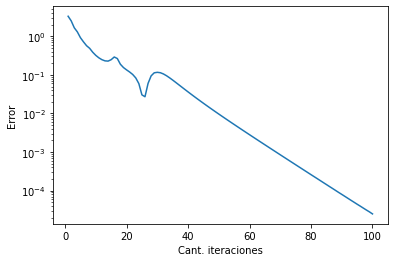

In [60]:
max_iteraciones = 100

res0 = expIteraciones(max_iteraciones)
axis0 = [j for j in range(max_iteraciones+1) if j > 0]

plt.xlabel("Cant. iteraciones")
plt.ylabel("Error")
plt.plot(axis0, res0)
plt.yscale("log")

plt.savefig("./graficos/error_iteraciones.png", bbox_inches = 'tight');

## Error segun tamanio de matriz

2 1.1308200066613372e-07
3 6.083802571814037e-07
4 0.0
5 8.11544948533315e-16
6 1.2944132315863957e-06
7 1.760614876432892e-06
8 8.659361169384358e-07
9 3.4523440076002842e-06
10 2.4888516736040014e-05
11 1.967329385174676e-05
12 0.05748645961231024
13 4.978716221082104e-05
14 0.00014666860297132516
15 0.0002884352043312102
16 0.0005420225564200349
17 0.0010291872230452606
18 0.0009357172930830484
19 0.0008685014561381255
20 0.00517251429098919
21 0.0019858400251228665
22 0.004830102213663999
23 0.002893461297503491
24 0.0056923594362501715
25 0.005712917110503403
26 0.008182555570523121
27 0.041321914381081244
28 0.023071652678899403
29 0.012774234992365253
30 0.011558145347640011
31 0.0177012617477035
32 0.04621427511568626
33 0.019994336964988965
34 0.019351196849342236
35 0.016448990055291348
36 0.0448809592018076
37 0.06287308954664417
38 0.044143845817788886
39 0.06988621197043651
40 0.05210251552368183
41 0.09702097736240747
42 0.05896221749073731
43 0.10538910924602403
44 0.052

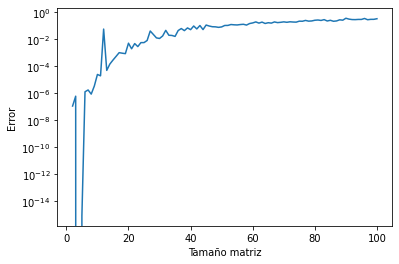

In [24]:
max_tamanio_matrix = 100

res = expMatricesCrecientes(max_tamanio_matrix)
axis = [j for j in range(max_tamanio_matrix+1) if j > 1]
#print(res)
plt.xlabel("Tamaño matriz")
plt.ylabel("Error")
plt.plot(axis, res)
plt.yscale("log")

plt.savefig("./graficos/error_tamanio.png", bbox_inches = 'tight');

# Experimentacion con autovalores parecidos

In [52]:
def expIteracionesAutovaloresParecidos(max_iteraciones):
    res = []
    for i in range(max_iteraciones+1):
        if i < 1: continue
        D = np.diag([5, 4.9, 4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1])

        v = np.ones((D.shape[0], 1))

        v = v / np.linalg.norm(v)

        # Matriz de Householder
        B = np.eye(D.shape[0]) - 2 * (v @ v.T)
    
        # Matriz a diagonalizar
        M = B.T @ D @ B

        printToFile(M, F"{path_instancias}/expIteracionesAutovaloresParecidos1.txt")

        a, b = Autovalores(F"{path_instancias}/expIteracionesAutovaloresParecidos1.txt", i, eps)
        errores = []
        for j in range(9, 0 , -1):
            Av = M @ b[:, j]
            ev = a[j] * b[:, j]

            errores.append(np.linalg.norm(Av - ev))
        print(str(i) + " " + str(np.mean(errores)))
        res.append(np.mean(errores))
    return res

In [53]:
max_iteraciones = 100

res1 = expIteracionesAutovaloresParecidos(max_iteraciones)
axis1 = [j for j in range(max_iteraciones+1) if j > 0]

1 0.3238507915215145
2 0.24128312697299897
3 0.2407522650195396
4 0.2390893225114165
5 0.2438205313244374
6 0.2521952450435263
7 0.2502505927770009
8 0.24560826347730824
9 0.24202700239000116
10 0.238865478456198
11 0.2350215384370174
12 0.22973743236127728
13 0.2227877554460087
14 0.2143720308977091
15 0.2048005917179757
16 0.1942159258355689
17 0.18255610882475629
18 0.17003658019547568
19 0.1589307643521506
20 0.15585823900523177
21 0.16639769500811363
22 0.14588386326147043
23 0.16153129099934874
24 0.15549241730645466
25 0.14710462850917339
26 0.14028981809777957
27 0.13438915790949946
28 0.12911224409337602
29 0.12432466411873608
30 0.11994914236202862
31 0.11593013311197511
32 0.11222105193110093
33 0.10877915419020848
34 0.10556284093066527
35 0.10252992103596678
36 0.09963618416191942
37 0.09683379087264743
38 0.09407086042799946
39 0.09129172173127582
40 0.08844090963576406
41 0.08547358364935358
42 0.0823766084545636
43 0.07920710853447858
44 0.07615622936100097
45 0.0736069

In [54]:
def expIteracionesAutovaloresParecidos(max_iteraciones):
    res = []
    for i in range(max_iteraciones+1):
        if i < 1: continue
        D = np.diag([5, 4.99, 4.98, 4.97, 4.96, 4.95, 4.94, 4.93, 4.92, 4.91])

        v = np.ones((D.shape[0], 1))

        v = v / np.linalg.norm(v)

        # Matriz de Householder
        B = np.eye(D.shape[0]) - 2 * (v @ v.T)
    
        # Matriz a diagonalizar
        M = B.T @ D @ B

        printToFile(M, F"{path_instancias}/expIteracionesAutovaloresParecidos2.txt")

        a, b = Autovalores(F"{path_instancias}/expIteracionesAutovaloresParecidos2.txt", i, eps)
        errores = []
        for j in range(9, 0 , -1):
            Av = M @ b[:, j]
            ev = a[j] * b[:, j]

            errores.append(np.linalg.norm(Av - ev))
        print(str(i) + " " + str(np.mean(errores)))
        res.append(np.mean(errores))
    return res

In [55]:
max_iteraciones = 100

res2 = expIteracionesAutovaloresParecidos(max_iteraciones)
axis2 = [j for j in range(max_iteraciones+1) if j > 0]

1 0.023860440903087598
2 0.02386464625338837
3 0.02387210914642686
4 0.02387907326556006
5 0.023885510374662917
6 0.02389136930567609
7 0.02389662897555665
8 0.023901217928192206
9 0.02390509626986786
10 0.023908227723832706
11 0.023910509660946357
12 0.023911917669095457
13 0.023912372776090773
14 0.023911801785515815
15 0.0239101352718463
16 0.023907339843278086
17 0.02390331352135343
18 0.02389803686883617
19 0.023891445692165524
20 0.02388354546095062
21 0.023874304163673886
22 0.023863734087243745
23 0.02385191266691626
24 0.023838909883437676
25 0.023824881172351892
26 0.02381003001585707
27 0.023794632542511764
28 0.023779024049746193
29 0.023763651915692133
30 0.02374906948298202
31 0.023735887406495
32 0.023724881257043293
33 0.023716872141665523
34 0.023712774664405464
35 0.023713579606497982
36 0.02372027007497159
37 0.023733837437826855
38 0.023755165503063735
39 0.02378504118866784
40 0.02382401907499496
41 0.023872396189336238
42 0.023930192797230555
43 0.0239970323903528

In [56]:
def expIteracionesAutovaloresParecidos(max_iteraciones):
    res = []
    for i in range(max_iteraciones+1):
        if i < 1: continue
        D = np.diag([5, 4.999, 4.998, 4.997, 4.996, 4.995, 4.994, 4.993, 4.992, 4.991])

        v = np.ones((D.shape[0], 1))

        v = v / np.linalg.norm(v)

        # Matriz de Householder
        B = np.eye(D.shape[0]) - 2 * (v @ v.T)
    
        # Matriz a diagonalizar
        M = B.T @ D @ B

        printToFile(M, F"{path_instancias}/expIteracionesAutovaloresParecidos3.txt")

        a, b = Autovalores(F"{path_instancias}/expIteracionesAutovaloresParecidos3.txt", i, eps)
        errores = []
        for j in range(9, 0 , -1):
            Av = M @ b[:, j]
            ev = a[j] * b[:, j]

            errores.append(np.linalg.norm(Av - ev))
        print(str(i) + " " + str(np.mean(errores)))
        res.append(np.mean(errores))
    return res

In [57]:
max_iteraciones = 100

res3 = expIteracionesAutovaloresParecidos(max_iteraciones)
axis3 = [j for j in range(max_iteraciones+1) if j > 0]

1 0.0023838731834140117
2 0.0023839483356606476
3 0.002384025147220981
4 0.0023841027422945413
5 0.002384180136243008
6 0.002384258163737341
7 0.0023843349622523382
8 0.002384410570203804
9 0.002384485547342246
10 0.002384560730227775
11 0.0023846363071852016
12 0.0023847097590941595
13 0.0023847828064292565
14 0.0023848556802049765
15 0.0023849296977146747
16 0.002385002891069886
17 0.002385072993102607
18 0.002385144578006133
19 0.00238521597532387
20 0.0023852879940920624
21 0.0023853578570452744
22 0.0023854265446400197
23 0.0023854956806247988
24 0.002385562969158374
25 0.0023856326386317607
26 0.0023857000466119297
27 0.002385765914924349
28 0.002385832728924541
29 0.0023858986663720383
30 0.002385965555297988
31 0.0023860303504939333
32 0.002386094503235436
33 0.002386157229869394
34 0.0023862202234063226
35 0.002386283904310501
36 0.0023863462184908367
37 0.0023864085533148558
38 0.0023864695126624273
39 0.002386529153026328
40 0.002386589799595238
41 0.0023866489600276393
42 0

In [115]:
def expIteracionesAutovaloresParecidos(max_iteraciones):
    res = []
    for i in range(max_iteraciones+1):
        if i < 1: continue
        D = np.diag([5, 4.9999, 4.9998, 4.9997, 4.9996, 4.9995, 4.9994, 4.9993, 4.9992, 4.9991])

        v = np.ones((D.shape[0], 1))

        v = v / np.linalg.norm(v)

        # Matriz de Householder
        B = np.eye(D.shape[0]) - 2 * (v @ v.T)
    
        # Matriz a diagonalizar
        M = B.T @ D @ B

        printToFile(M, F"{path_instancias}/expIteracionesAutovaloresParecidos4.txt")

        a, b = Autovalores(F"{path_instancias}/expIteracionesAutovaloresParecidos4.txt", i, eps)
        errores = []
        for j in range(9, 0 , -1):
            Av = M @ b[:, j]
            ev = a[j] * b[:, j]

            errores.append(np.linalg.norm(Av - ev))
        print(str(i) + " " + str(np.mean(errores)))
        res.append(np.mean(errores))
    return res

In [116]:
max_iteraciones = 100

res4 = expIteracionesAutovaloresParecidos(max_iteraciones)
axis4 = [j for j in range(max_iteraciones+1) if j > 0]

1 0.000238386680022402
2 0.00023838737746187982
3 0.00023838811567401114
4 0.0002383888618572388
5 0.00023838964781776675
6 0.00023839045987022992
7 0.0002383912122947289
8 0.00023839193401355857
9 0.00023839270478649742
10 0.00023839347417592248
11 0.00023839431743819984
12 0.00023839499473182724
13 0.00023839580385269607
14 0.00023839655952803202
15 0.00023839737904966308
16 0.0002383980927612944
17 0.00023839891728493596
18 0.00023839962268230842
19 0.00023840043643228747
20 0.00023840127566122246
21 0.00023840202454163543
22 0.00023840279648768519
23 0.0002384035086060353
24 0.00023840435644351585
25 0.000238405139783346
26 0.00023840592238506423
27 0.00023840672100558676
28 0.0002384074805163334
29 0.00023840824465724922
30 0.00023840902215303952
31 0.0002384098065359334
32 0.00023841060934613783
33 0.00023841132131237051
34 0.00023841212402148923
35 0.00023841298431513726
36 0.00023841370830931635
37 0.00023841451748618118
38 0.00023841530254547645
39 0.0002384160712183336
40 0.0

In [120]:
def expIteracionesAutovaloresParecidos(max_iteraciones):
    res = []
    for i in range(max_iteraciones+1):
        if i < 1: continue
        D = np.diag([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0])

        v = np.ones((D.shape[0], 1))

        v = v / np.linalg.norm(v)

        # Matriz de Householder
        B = np.eye(D.shape[0]) - 2 * (v @ v.T)
    
        # Matriz a diagonalizar
        M = B.T @ D @ B

        printToFile(M, F"{path_instancias}/expIteracionesAutovaloresParecidos5.txt")

        a, b = Autovalores(F"{path_instancias}/expIteracionesAutovaloresParecidos5.txt", i, eps)
        errores = []
        for j in range(9, 0 , -1):
            Av = M @ b[:, j]
            ev = a[j] * b[:, j]

            errores.append(np.linalg.norm(Av - ev))
        print(str(i) + " " + str(np.mean(errores)))
        res.append(np.mean(errores))
    return res

In [121]:
max_iteraciones = 100

res5 = expIteracionesAutovaloresParecidos(max_iteraciones)
axis5 = [j for j in range(max_iteraciones+1) if j > 0]

1 1.0401120190021622e-15
2 1.0401120190021622e-15
3 1.0401120190021622e-15
4 1.0401120190021622e-15
5 1.0401120190021622e-15
6 1.0401120190021622e-15
7 1.0401120190021622e-15
8 1.0401120190021622e-15
9 1.0401120190021622e-15
10 1.0401120190021622e-15
11 1.0401120190021622e-15
12 1.0401120190021622e-15
13 1.0401120190021622e-15
14 1.0401120190021622e-15
15 1.0401120190021622e-15
16 1.0401120190021622e-15
17 1.0401120190021622e-15
18 1.0401120190021622e-15
19 1.0401120190021622e-15
20 1.0401120190021622e-15
21 1.0401120190021622e-15
22 1.0401120190021622e-15
23 1.0401120190021622e-15
24 1.0401120190021622e-15
25 1.0401120190021622e-15
26 1.0401120190021622e-15
27 1.0401120190021622e-15
28 1.0401120190021622e-15
29 1.0401120190021622e-15
30 1.0401120190021622e-15
31 1.0401120190021622e-15
32 1.0401120190021622e-15
33 1.0401120190021622e-15
34 1.0401120190021622e-15
35 1.0401120190021622e-15
36 1.0401120190021622e-15
37 1.0401120190021622e-15
38 1.0401120190021622e-15
39 1.0401120190021622

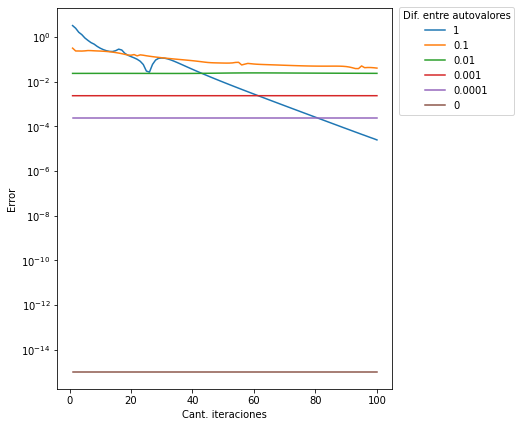

In [157]:
plt.figure(figsize=(6,7))

plt.xlabel("Cant. iteraciones")
plt.ylabel("Error")

plt.plot(axis0, res0, label="1")
plt.plot(axis1, res1, label="0.1")
plt.plot(axis2, res2, label="0.01")
plt.plot(axis3, res3, label="0.001")
plt.plot(axis4, res4, label="0.0001")
plt.plot(axis5, res5, label="0")

plt.legend(loc="upper right", bbox_to_anchor=(0., 0.915, 1.38, 0.102), title='Dif. entre autovalores', ncol=1)
plt.yscale("log")

plt.savefig("./graficos/error_iteraciones_autoval_parecidos.png", bbox_inches = 'tight');